<a href="https://colab.research.google.com/github/mortgad/DLVR/blob/main/colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Loading the data

In [1]:
!pip install PyDrive

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os
import tarfile

# Authenticate PyDrive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Folder ID from the shared Google Drive folder
folder_id = '1HROmgviy4jUUUaCdvvrQ8PcqtNg2jn3G'
file_list = drive.ListFile({'q': f"'{folder_id}' in parents and trashed=false"}).GetList()

# Loop through the files and download each .tar.gz file
for file in file_list:
    if file['title'].endswith('.tar.gz'):
        print(f'Downloading {file["title"]}')
        file.GetContentFile(file['title'])

        # Extract the .tar.gz file
        tar = tarfile.open(file['title'])
        tar.extractall('/content/extracted')  # Extract all files to /content/extracted directory
        tar.close()

        print(f'Extracted {file["title"]}')

Extracted part3.tar.gz
Extracted part2.tar.gz
Extracted part1.tar.gz


# 2. Data Test

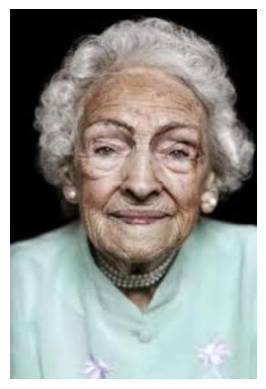

Shape: (551, 368, 3)


In [ ]:
import cv2
import matplotlib.pyplot as plt

file_path = '/content/extracted/part3/100_1_0_20170119212053665.jpg'
image = cv2.imread(file_path)

# Convert BGR to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(image_rgb)
plt.axis('off')  # Hide axes
plt.show()

# Print the shape of the image
print(f"Shape: {image.shape}")


# 3. Data Preprocessing

## Delete non-images

In [3]:
import os

def delete_non_image_files(directories, allowed_extensions=('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
    for directory in directories:
        for filename in os.listdir(directory):
            if not filename.lower().endswith(allowed_extensions):
                file_path = os.path.join(directory, filename)
                os.remove(file_path)
                print(f"Deleted: {file_path}")

# Specify the directories
directories = [
    '/content/extracted/part1',
    '/content/extracted/part2',
    '/content/extracted/part3'
]

# Run the function to delete non-image files
delete_non_image_files(directories)

Deleted: /content/extracted/part3/55_0_0_20170116232725357jpg
Deleted: /content/extracted/part3/.DS_Store
Deleted: /content/extracted/part3/44_1_4_20170116235150272.pg


## Delete invalid mesasges

In [4]:
import os
import re

def delete_invalid_images(directories):
    # Regular expression pattern to match the desired format
    pattern = re.compile(r'^\d+_\d+_\d+_\d+\.\w+$')

    for directory in directories:
        for filename in os.listdir(directory):
            # Check if the filename matches the desired pattern
            if not pattern.match(filename):
                file_path = os.path.join(directory, filename)
                os.remove(file_path)
                print(f"Deleted: {file_path}")

# Specify the directories
directories = [
    '/content/extracted/part1',
    '/content/extracted/part2',
    '/content/extracted/part3'
]

# Run the function to delete invalid images
delete_invalid_images(directories)

Deleted: /content/extracted/part1/61_1_20170109142408075.jpg
Deleted: /content/extracted/part1/61_3_20170109150557335.jpg
Deleted: /content/extracted/part2/53__0_20170116184028385.jpg
Deleted: /content/extracted/part2/39_1_20170116174525125.jpg
Deleted: /content/extracted/part3/24_0_1_20170116220224657 .jpg


## Resizing images
- Adjust target size when experimenting
- Inception V3 size: (299,299,3)

In [5]:
import cv2
import os

target_size = (299,299)

def resize_images_in_directories(directories, target_size):
    supported_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')

    for directory in directories:
        for filename in os.listdir(directory):
            if filename.lower().endswith(supported_extensions):
                file_path = os.path.join(directory, filename)

                # Read the image
                image = cv2.imread(file_path)

                if image is not None:
                    # Resize the image to the target size
                    resized_image = cv2.resize(image, target_size)

                    # Save the resized image back to the same path, or specify a different path if needed
                    cv2.imwrite(file_path, resized_image)
                else:
                    print(f"Warning: Failed to load {file_path}, skipping.")
            else:
                print(f"Skipping non-image file: {filename}")

# Specify the directories
directories = [
    '/content/extracted/part1',
    '/content/extracted/part2',
    '/content/extracted/part3'
]

resize_images_in_directories(directories, target_size)

## Counting images

In [6]:
import os

def count_files_in_directories(directories):
    file_counts = {}

    for directory in directories:
        count = len(os.listdir(directory))
        file_counts[directory] = count

    return file_counts

# Specify the directories
directories = [
    '/content/extracted/part1',
    '/content/extracted/part2',
    '/content/extracted/part3'
]

# Run the function and print the counts
file_counts = count_files_in_directories(directories)

for directory, count in file_counts.items():
    print(f"Number of files in {directory}: {count}")

Number of files in /content/extracted/part1: 10135
Number of files in /content/extracted/part2: 10717
Number of files in /content/extracted/part3: 3249


## Creating lists for training

In [7]:
import os
import cv2
import numpy as np
import pandas as pd

# Specify the directories
directories = [
    '/content/extracted/part1',
    '/content/extracted/part2',
    '/content/extracted/part3'
]

# Process each directory
i = 1  # Moved this outside the loop to avoid resetting
# Initialize lists to store images and labels
images = []
ages = []
genders = []
ethnicities = []

for directory in directories:
    print(f"Processing from: {directory}")
    files = os.listdir(directory)

    for file in files:
        file_path = os.path.join(directory, file)

        # Read the image
        image = cv2.imread(file_path)

        if image is not None:  # Check if the image was loaded successfully
            # Convert BGR to RGB
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Append the flattened image and labels to their respective lists
            images.append(image_rgb)
            split_var = file.split('_')
            ages.append(int(split_var[0]))
            genders.append(int(split_var[1]))
            ethnicities.append(int(split_var[2]))
        else:
            print(f"Failed to load image: {file_path}")

    i += 1  # Increment the counter


Processing from: /content/extracted/part1
Processing from: /content/extracted/part2
Processing from: /content/extracted/part3


In [8]:
# After processing each directory, you can print the lengths of your lists:
print(f"Length of ages: {len(ages)}")
print(f"Length of genders: {len(genders)}")
print(f"Length of ethnicities: {len(ethnicities)}")
print(f"Length of images: {len(images)}")

Length of ages: 24101
Length of genders: 24101
Length of ethnicities: 24101
Length of images: 24101


array([[[227, 244, 252],
        [227, 244, 252],
        [227, 244, 252],
        ...,
        [234, 247, 255],
        [234, 247, 255],
        [234, 247, 255]],

       [[228, 245, 253],
        [227, 244, 252],
        [227, 244, 252],
        ...,
        [234, 247, 255],
        [234, 247, 255],
        [234, 247, 255]],

       [[229, 246, 254],
        [229, 246, 254],
        [228, 245, 253],
        ...,
        [234, 247, 255],
        [234, 247, 255],
        [234, 247, 255]],

       ...,

       [[247, 204, 172],
        [246, 203, 171],
        [245, 200, 169],
        ...,
        [146, 118, 107],
        [141, 113, 102],
        [137, 109,  97]],

       [[247, 204, 172],
        [246, 203, 171],
        [246, 201, 170],
        ...,
        [157, 129, 118],
        [151, 123, 112],
        [147, 119, 107]],

       [[248, 205, 173],
        [247, 204, 172],
        [247, 202, 171],
        ...,
        [163, 136, 125],
        [156, 129, 118],
        [151, 123, 111]]], dtype=uint8)
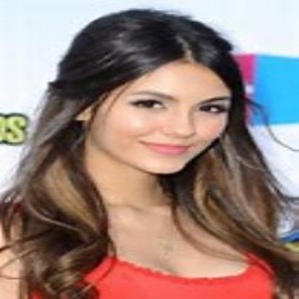

In [9]:
images[0]

# 4. EDA


In [ ]:
# Get libraries for loading data and plotting subgroups

import pandas as pd
import seaborn as sns
import matplotlib as plt
import numpy as np


# Make one dataframe with all lists:
# Creating DataFrame
df = pd.DataFrame({
    'Image': images,
    'Age': ages,
    'Gender': genders,
    'Ethnicity': ethnicities
})

df.head(10)

,Image,Age,Gender,Ethnicity
0,"[[[227, 244, 252], [227, 244, 252], [226, 243,...",20,1,4
1,"[[[10, 11, 6], [10, 11, 6], [9, 10, 5], [9, 10...",2,1,2
2,"[[[165, 164, 160], [167, 166, 162], [169, 168,...",4,0,2
3,"[[[48, 43, 40], [48, 43, 40], [48, 43, 40], [4...",28,0,3
4,"[[[91, 95, 98], [0, 0, 0], [8, 1, 0], [9, 0, 0...",52,1,0
5,"[[[8, 7, 3], [22, 21, 17], [34, 30, 27], [14, ...",90,0,0
6,"[[[150, 210, 218], [152, 211, 219], [156, 210,...",8,1,0
7,"[[[64, 66, 55], [61, 63, 52], [62, 65, 54], [5...",54,1,0
8,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",1,1,3
9,"[[[26, 18, 0], [27, 15, 0], [29, 11, 0], [38, ...",85,0,0


In [ ]:
# As the img_name have no relevance for predictions, it is deleted.
df = df.drop("Image", axis = 1)

# Looking at simple descriptive statistic, which may only be releveant for the numeric collumn age
df.describe()

# We see that there are age from 1 - 116. It could be discussed whehter pictures of babies are needed to build this model.
# I should maybe also discuss whether 116 is an outlier.

,Age,Gender,Ethnicity
count,24101.000000,24101.000000,24101.000000
mean,33.042156,0.478030,1.271731
std,20.139284,0.499527,1.343888
min,1.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000
50%,29.000000,0.000000,1.000000
75%,45.000000,1.000000,2.000000
max,116.000000,1.000000,4.000000


<Axes: xlabel='Ethnicity', ylabel='count'>

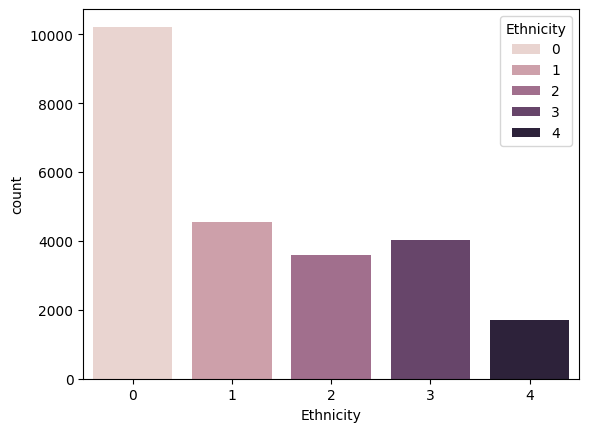

In [ ]:
# Look at the categorical variables.

# First Ethnicity
sns.countplot(data=df, x ='Ethnicity', hue ='Ethnicity')

# There are way more white people than any other Ethnicity

<Axes: xlabel='Gender', ylabel='count'>

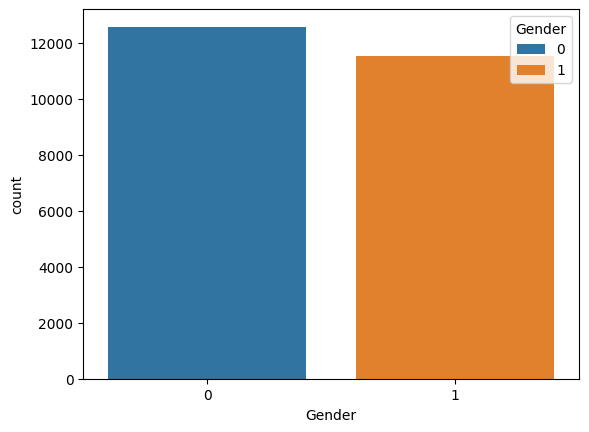

In [ ]:
# Then gender distribution is almost perfectly 50/50
sns.countplot(data=df, x ='Gender', hue ='Gender')

<Axes: xlabel='Age', ylabel='Density'>

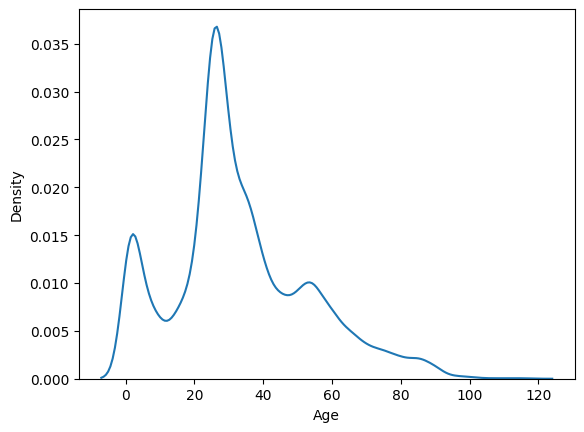

In [ ]:
# Plot of the age for all observations:
sns.kdeplot(data=df, x='Age')

# It may be a bit problematic, there is only a few of the observations which is around the threshold
# between 15-20 which is where we will have our cut off.

<Axes: xlabel='Age', ylabel='Density'>

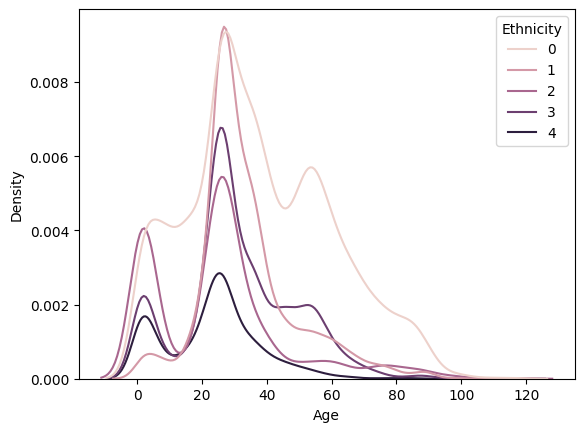

In [ ]:
# Plot age for the etnicity to tell if it is the same acroos all etnicities
sns.kdeplot(data=df, x='Age', hue='Ethnicity')

# We see that the distribution of age throughout the classes are almost the same with the exeption
# of 0 which have more peoepl between 15-20 as well as 60-65

# 5. Regression Models using sub-part of data

## Preprocessing for a sub part of the data.

In [ ]:
# Convert your labels to numpy arrays
ages_array = np.array(ages)
genders_array = np.array(genders)
ethnicities_array = np.array(ethnicities)
images_array = np.array(images)

# Select subset of data
images_subset = images_array[:2000]
ages_subset = ages_array[:2000]
genders_subset = genders_array[:2000]
ethnicities_subset = ethnicities_array[:2000]

# Normalize
images_subset = images_subset /255.0

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(images_subset, ages_subset, test_size=0.2,shuffle  = True)

##Example 1 -- Small homemade model

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input

# Building the Sequential model
model = Sequential()

# Adding the Input layer explicitly with shape (224, 224, 3)
model.add(Input(shape=(224, 224, 3)))

# Convolutional layers with ReLU activation and MaxPooling
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flattening the output before feeding into Dense layers
model.add(Flatten())

# Dense layer with 64 units and ReLU activation
model.add(Dense(64, activation='relu'))

# Output layer for regression (1 output for age)
model.add(Dense(1))  # No activation or linear (default for regression)

# Compile the model with mean_squared_error loss function and Adam optimizer
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Train the model
model.fit(x_train, y_train, epochs=10, batch_size=32,validation_data=(x_test,y_test))

Epoch 1/10
50/50 [==============================] - 14s 261ms/step - loss: 1037.0350 - mean_absolute_error: 25.4156 - val_loss: 762.1317 - val_mean_absolute_error: 21.9873
Epoch 2/10
50/50 [==============================] - 13s 251ms/step - loss: 629.4100 - mean_absolute_error: 20.7675 - val_loss: 648.0220 - val_mean_absolute_error: 20.4149
Epoch 3/10
50/50 [==============================] - 13s 255ms/step - loss: 546.7781 - mean_absolute_error: 19.0382 - val_loss: 599.4694 - val_mean_absolute_error: 20.6011
Epoch 4/10
50/50 [==============================] - 13s 254ms/step - loss: 489.9562 - mean_absolute_error: 18.1018 - val_loss: 565.5044 - val_mean_absolute_error: 19.1698
Epoch 5/10
50/50 [==============================] - 13s 252ms/step - loss: 472.8340 - mean_absolute_error: 17.6083 - val_loss: 565.7286 - val_mean_absolute_error: 19.0844
Epoch 6/10
50/50 [==============================] - 13s 253ms/step - loss: 438.2677 - mean_absolute_error: 16.7424 - val_loss: 571.0479 - val_me

## Example 2 -- Slightly larger homemade model

In [ ]:
import keras
from keras import layers, models  # Import the required modules

# Input layer
inputs = keras.Input(shape=(224, 224, 3))

x = layers.Rescaling(1./255)(inputs)
# First Convolutional Block
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Second Convolutional Block
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Third Convolutional Block
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Flatten and Dense Layers
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation='relu')(x)  # 10 classes in CIFAR-10

# Model creation
model = models.Model(inputs=inputs, outputs=outputs)

# Display model summary
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                        

In [ ]:
model.compile(optimizer='adam',
              loss='mae',
              metrics=['mae'])


# Now you can train your model
history = model.fit(x_train, y_train, epochs=10,
                    batch_size=32,
                    validation_data = (x_test, y_test))

history = model.fit(x_train, y_train, epochs=10,
                    validation_data = (x_test, y_test))

Epoch 1/10
50/50 [==============================] - 22s 425ms/step - loss: 22.1879 - mae: 22.1879 - val_loss: 21.2383 - val_mae: 21.2383
Epoch 2/10
50/50 [==============================] - 21s 412ms/step - loss: 20.8519 - mae: 20.8519 - val_loss: 20.7659 - val_mae: 20.7659
Epoch 3/10
50/50 [==============================] - 20s 405ms/step - loss: 20.5604 - mae: 20.5604 - val_loss: 19.6273 - val_mae: 19.6273
Epoch 4/10
50/50 [==============================] - 20s 404ms/step - loss: 20.1753 - mae: 20.1753 - val_loss: 18.7297 - val_mae: 18.7297
Epoch 5/10
50/50 [==============================] - 20s 404ms/step - loss: 19.1903 - mae: 19.1903 - val_loss: 18.0645 - val_mae: 18.0645
Epoch 6/10
50/50 [==============================] - 20s 402ms/step - loss: 19.2341 - mae: 19.2341 - val_loss: 18.5726 - val_mae: 18.5726
Epoch 7/10
50/50 [==============================] - 20s 399ms/step - loss: 19.3065 - mae: 19.3065 - val_loss: 18.0503 - val_mae: 18.0503
Epoch 8/10
50/50 [=======================

## Transfer learning with inceptionV3

In [ ]:
from keras import layers
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import keras
from keras.layers import *
from keras.models import *
from keras import backend as K
from keras.applications import InceptionV3
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
conv_base = keras.applications.InceptionV3(
    include_top=False,  # Exclude the top fully connected layers
    weights="imagenet"  # Load pre-trained ImageNet weights
)

conv_base.trainable = False  # Freeze the pre-trained layers


In [ ]:
inputs = keras.Input(shape=(images[0].shape[0],images[0].shape[1],images[0].shape[2]))
x = keras.applications.inception_v3.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation="relu")(x)  # Add activation function (e.g., ReLU)
x = layers.Dense(512, activation="relu")(x)  # Add activation function (e.g., ReLU)
x = layers.Dropout(0.3)(x)  # Increased dropout for better regularization
outputs = layers.Dense(1, activation="relu")(x)

inception = keras.Model(inputs=inputs, outputs=outputs)
inception.summary()


# Set custom learning rate for RMSProp optimizer
learning_rate = 0.001  # Adjust as needed
rmsprop_optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)

inception.compile(loss="mae",
                  optimizer=rmsprop_optimizer,
                  metrics=["mae"])

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_1 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048   21802784  
                             )                                   
                                                                 
 flatten_5 (Flatten)         (None, 51200)             0         
                                                           

In [ ]:
inception_history = inception.fit(
    x_train,
    y_train,
    epochs = 10,
    validation_data = (x_test, y_test))

Epoch 1/10
50/50 [==============================] - 23s 363ms/step - loss: 30.0381 - mae: 30.0381 - val_loss: 28.6325 - val_mae: 28.6325
Epoch 2/10
50/50 [==============================] - 16s 324ms/step - loss: 28.6912 - mae: 28.6912 - val_loss: 28.6325 - val_mae: 28.6325
Epoch 3/10
50/50 [==============================] - 16s 327ms/step - loss: 28.6912 - mae: 28.6912 - val_loss: 28.6325 - val_mae: 28.6325
Epoch 4/10
50/50 [==============================] - 16s 330ms/step - loss: 28.6912 - mae: 28.6912 - val_loss: 28.6325 - val_mae: 28.6325
Epoch 5/10
50/50 [==============================] - 16s 323ms/step - loss: 28.6912 - mae: 28.6912 - val_loss: 28.6325 - val_mae: 28.6325
Epoch 6/10
50/50 [==============================] - 17s 341ms/step - loss: 28.6912 - mae: 28.6912 - val_loss: 28.6325 - val_mae: 28.6325
Epoch 7/10
50/50 [==============================] - 16s 331ms/step - loss: 28.6912 - mae: 28.6912 - val_loss: 28.6325 - val_mae: 28.6325
Epoch 8/10
50/50 [=======================

In [ ]:
########## We dont use this as we are predicting numeric. However we might need it for later when we put people into age groups.###################

# Get the predicted probabilities
y_pred_probs = inception.predict(x_test)

# Convert the probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# If y_test is one-hot encoded, convert it back to class labels
y_true = np.argmax(y_test, axis=1)

# Get confusion matrix
# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Class names
class_names = age_groups.columns

# Plot confusion matrix with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 6. Regression Models on full dataset

## Data preparation for all data

In [ ]:
# Convert your labels to numpy arrays
ages = np.array(ages)
genders = np.array(genders)
ethnicities = np.array(ethnicities)
images = np.array(images)

# Normalize entire dataset
images = images /255.0

In [ ]:
# Consistency check --> All appear to be fine
print("Length of ages_array:", len(ages))
print("Length of genders_array:", len(genders))
print("Length of ethnicities_array:", len(ethnicities))
print("Length of images_array:", len(images))

Length of ages_array: 24101
Length of genders_array: 24101
Length of ethnicities_array: 24101
Length of images_array: 24101


In [ ]:
# Getting training and test data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(images, ages, test_size=0.2,shuffle  = True)

## Small homemade model

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input

# Building the Sequential model
model = Sequential()

# Adding the Input layer explicitly with shape (224, 224, 3)
model.add(Input(shape=(224, 224, 3)))

# Convolutional layers with ReLU activation and MaxPooling
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flattening the output before feeding into Dense layers
model.add(Flatten())

# Dense layer with 64 units and ReLU activation
model.add(Dense(64, activation='relu'))

# Output layer for regression (1 output for age)
model.add(Dense(1))  # No activation or linear (default for regression)

# Compile the model with mean_squared_error loss function and Adam optimizer
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Train the model
model.fit(x_train, y_train, epochs=10, batch_size=32,validation_data=(x_test,y_test))

Epoch 1/10
603/603 [==============================] - 161s 266ms/step - loss: 1484.0032 - mean_absolute_error: 32.7710 - val_loss: 1500.4591 - val_mean_absolute_error: 32.9207
Epoch 2/10
603/603 [==============================] - 155s 257ms/step - loss: 1430.2340 - mean_absolute_error: 32.0559 - val_loss: 1461.9413 - val_mean_absolute_error: 32.3495
Epoch 3/10
603/603 [==============================] - 153s 254ms/step - loss: 1392.7925 - mean_absolute_error: 31.5148 - val_loss: 1424.2252 - val_mean_absolute_error: 31.8272
Epoch 4/10
603/603 [==============================] - 153s 254ms/step - loss: 1356.1556 - mean_absolute_error: 30.9919 - val_loss: 1387.3282 - val_mean_absolute_error: 31.3215
Epoch 5/10
603/603 [==============================] - 154s 256ms/step - loss: 1320.3806 - mean_absolute_error: 30.4932 - val_loss: 1351.3138 - val_mean_absolute_error: 30.8289
Epoch 6/10
603/603 [==============================] - 156s 259ms/step - loss: 1285.4086 - mean_absolute_error: 30.0024 -

## InceptionV3

In [ ]:
import keras
from keras import layers, models  # Import the required modules

conv_base = keras.applications.InceptionV3(
    include_top=False,  # Exclude the top fully connected layers
    weights="imagenet",  # Load pre-trained ImageNet weights
    input_shape=(images[0].shape[0],images[0].shape[1],images[0].shape[2])
)

conv_base.trainable = False  # Freeze the pre-trained layers


87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
inputs = keras.Input(shape=(images[0].shape[0],images[0].shape[1],images[0].shape[2]))
x = keras.applications.inception_v3.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation="relu")(x)  # Add activation function (e.g., ReLU)
x = layers.Dense(512, activation="relu")(x)  # Add activation function (e.g., ReLU)
x = layers.Dropout(0.3)(x)  # Increased dropout for better regularization
outputs = layers.Dense(1, activation="relu")(x)

inception = keras.Model(inputs=inputs, outputs=outputs)
inception.summary()


# Set custom learning rate for RMSProp optimizer
learning_rate = 0.001  # Adjust as needed
rmsprop_optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)

inception.compile(loss="mae",
                  optimizer=rmsprop_optimizer,
                  metrics=["mae"])

inception_history = inception.fit(
    x_train,
    y_train,
    epochs = 10,
    batch_size = 32,
    validation_data = (x_test, y_test))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 75, 75, 3)         0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 75, 75, 3)         0         
 da)                                                             
                                                                 
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               104908

# 7. Classifier models on full data

## Data preparation

In [ ]:
# Convert your labels to numpy arrays
ages = np.array(ages)
genders = np.array(genders)
ethnicities = np.array(ethnicities)
images = np.array(images)

# Zero centered dataset
#images = images /255.0

# Normalize data by subtracting the mean from each dimension

### One-hot encode

In [11]:
# Convert all values in the ages list to integers
ages_int = [int(age) for age in ages]

# Convert the ages to a DataFrame
ages_df = pd.DataFrame(ages_int, columns=['age'])

# Define the age bins and labels
bins = [0, 9, 18, 27, 36, 45, 54, 63, 72, 81, float('inf')]
labels = ['0-9', '9-18', '18-27', '27-36', '36-45', '45-54', '54-63', '63-72', '72-81', '81+']

# Create age groups - onehot encode
ages_df['age_group'] = pd.cut(ages_df['age'], bins=bins, labels=labels, right=False)

# One-hot encode the age groups
age_groups = pd.get_dummies(ages_df['age_group'])

num_classes = len(age_groups.columns)

# Example output
print(f"Age groups:\n{age_groups.head()}")
print(f"Number of classes: {num_classes}")

Age groups:
     0-9   9-18  18-27  27-36  36-45  45-54  54-63  63-72  72-81    81+
0   True  False  False  False  False  False  False  False  False  False
1  False  False  False  False   True  False  False  False  False  False
2  False   True  False  False  False  False  False  False  False  False
3   True  False  False  False  False  False  False  False  False  False
4  False   True  False  False  False  False  False  False  False  False
Number of classes: 10


In [12]:
# Getting training and test data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(images, age_groups, test_size=0.2,shuffle  = True)

### Sparse encoding

In [ ]:
# Convert all values in the ages list to integers
ages_int = [int(age) for age in ages]

# Convert the ages to a DataFrame
ages_df = pd.DataFrame(ages_int, columns=['age'])

bins = [0, 9, 18, 27, 36, 45, 54, 63, 72, 81, float('inf')]
labels = ['0-9', '9-18', '18-27', '27-36', '36-45', '45-54', '54-63', '63-72', '72-81', '81+']

# Create age groups with integer labels
ages_df['age_group'] = pd.cut(ages_df['age'], bins=bins, labels=False, right=False)

# Example output
print(f"Age groups (as sparse integers):\n{ages_df['age_group'].head()}")

num_classes = len(bins) - 1
print(f"Number of classes: {num_classes}")

In [ ]:
# Getting training and test data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(images, ages_df['age_group'], test_size=0.2,shuffle  = True)

## Small homemade model

In [ ]:
import keras
from keras import layers, models  # Import the required modules

# Input layer
inputs = keras.Input(shape=(images[0].shape[0],images[0].shape[1],images[0].shape[2]))

# First Convolutional Block
x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = layers.MaxPooling2D((2, 2))(x)

# Second Convolutional Block
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Third Convolutional Block
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Flatten and Dense Layers
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

# Model creation
model = models.Model(inputs=inputs, outputs=outputs)

# Display model summary
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 conv2d_97 (Conv2D)          (None, 73, 73, 32)        896       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_98 (Conv2D)          (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 17, 17, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_99 (Conv2D)          (None, 15, 15, 128)       7385

In [ ]:
# Set custom learning rate for RMSProp optimizer
learning_rate = 0.001  # Adjust as needed
rmsprop_optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)

model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=rmsprop_optimizer,
                  metrics=["accuracy"])

# Train the model
history = model.fit(x_train,
          y_train,
          epochs=10,
          batch_size=32,
          validation_data=(x_test,y_test))

Epoch 1/10
603/603 [==============================] - 19s 31ms/step - loss: 1.9527 - accuracy: 0.2795 - val_loss: 1.8836 - val_accuracy: 0.2977
Epoch 2/10
603/603 [==============================] - 17s 28ms/step - loss: 1.8289 - accuracy: 0.3262 - val_loss: 1.8024 - val_accuracy: 0.3375
Epoch 3/10
603/603 [==============================] - 17s 28ms/step - loss: 1.7356 - accuracy: 0.3567 - val_loss: 1.7158 - val_accuracy: 0.3566
Epoch 4/10
603/603 [==============================] - 17s 28ms/step - loss: 1.6288 - accuracy: 0.3949 - val_loss: 1.6817 - val_accuracy: 0.3622
Epoch 5/10
603/603 [==============================] - 17s 28ms/step - loss: 1.5279 - accuracy: 0.4340 - val_loss: 1.7530 - val_accuracy: 0.3624
Epoch 6/10
603/603 [==============================] - 17s 29ms/step - loss: 1.4127 - accuracy: 0.4775 - val_loss: 1.8448 - val_accuracy: 0.3244
Epoch 7/10
603/603 [==============================] - 17s 28ms/step - loss: 1.2790 - accuracy: 0.5283 - val_loss: 1.7873 - val_accuracy:

151/151 [==============================] - 1s 8ms/step


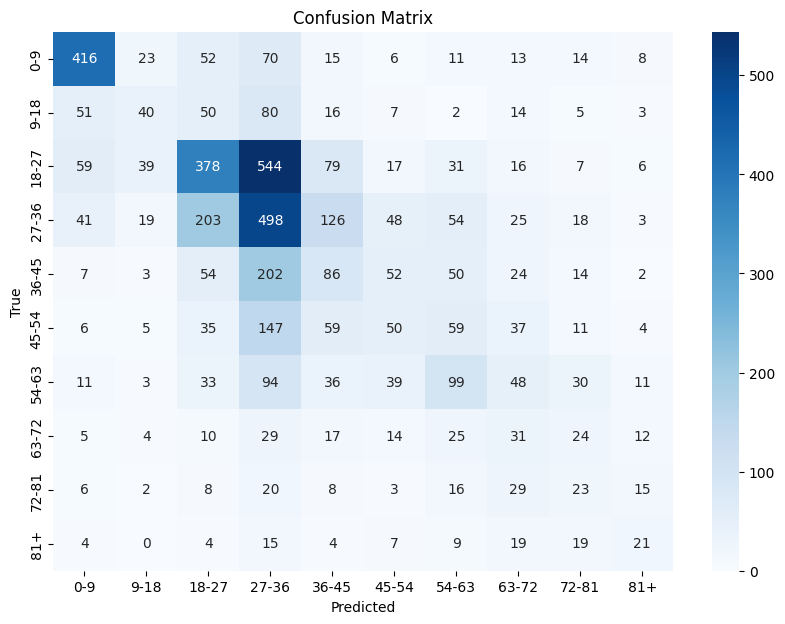

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Replace with actual model prediction logic, e.g., from a Keras or Scikit-learn model
# Example (for Keras): Assuming you have one-hot encoded predictions
y_pred = model.predict(x_test)  # x_test is your test data
y_pred = np.argmax(y_pred, axis=1)  # Convert one-hot to sparse integer predictions

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Inception V3

In [ ]:
from keras.applications.inception_v3 import preprocess_input

# Preprocess your images using the InceptionV3 preprocessing
images_preprocessed = preprocess_input(images)

# Now proceed with the model as before using the preprocessed images
conv_base = keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]),
    classes=num_classes
)

conv_base.trainable = False

In [ ]:
inputs = keras.Input(shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]))
x = conv_base(inputs)
x = layers.Flatten()(x)
x = layers.Dense(1024)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512)(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

In [ ]:
# Set custom learning rate for RMSProp optimizer
learning_rate = 1e-4  # Adjust as needed
optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
#optimizer = keras.optimizers.AdamW(learning_rate=learning_rate)
#optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy"])

inception_history = model.fit(
    x_train,
    y_train,
    epochs = 5,
    batch_size = 32,
    validation_data = (x_test, y_test))

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Replace with actual model prediction logic, e.g., from a Keras or Scikit-learn model
# Example (for Keras): Assuming you have one-hot encoded predictions
y_pred = model.predict(x_test)  # x_test is your test data
y_pred = np.argmax(y_pred, axis=1)  # Convert one-hot to sparse integer predictions

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()